## Extraction of data from UKHSA graph

This python script extracts data from graphs like: 

![image](input/a.png)

into raw data that can be used in further analyses.

In [1]:
def find_corners_and_crop(image):
    # find the top left and bottom right non-white pixels
    # in the image
    left = 0
    top = 0
    right = image.width
    bottom = image.height
    for x in range(image.width):
        for y in range(image.height):
            if image.getpixel((x, y)) != (255, 255, 255):
                left = x
                break
        if left != 0:
            break
    for x in range(image.width - 1, 0, -1):
        for y in range(image.height):
            if image.getpixel((x, y)) != (255, 255, 255):
                right = x
                break
        if right != image.width:
            break
    for y in range(image.height):
        for x in range(image.width):
            if image.getpixel((x, y)) != (255, 255, 255):
                top = y
                break
        if top != 0:
            break
    for y in range(image.height - 1, 0, -1):
        for x in range(image.width):
            if image.getpixel((x, y)) != (255, 255, 255):
                bottom = y
                break
        if bottom != image.height:
            break
    # crop the image to the bounding box
    cropped = image.crop((left, top, right, bottom))
    return cropped



In [2]:
def draw_rectangle(image, left, top, width, height):
    image2 = image.copy()
    draw = ImageDraw.Draw(image2)
    line_width = 1
    draw.rectangle((left*image.width, top*image.height, (left+width)*image.width, (top+height)*image.height), outline=(255, 0, 0), width=line_width)
    return image2

def get_rectangle(image, left, top, width, height):
    # return this cropped portion
    return image.crop((left*image.width, top*image.height, (left+width)*image.width, (top+height)*image.height))

### Get image and crop it to the exact size

In [3]:

from PIL import Image
from PIL import ImageDraw
from IPython.display import display
import pandas as pd
def open_image_and_crop(file):
    image = Image.open(file)
    image = find_corners_and_crop(image)
    return image

## Extract the colors from the key

In [4]:
def get_key(image):
    top = 0.35
    left = 0.723
    width = 0.08
    height = 0.34
    key = get_rectangle(image, left, top, width, height)
    display(draw_rectangle(image, left, top, width, height))

    num_colors = 7 
    spacing = 0.144
    left = 0
    width =1
    height = 0.05
    top=0
    colors = []
    for i in range(num_colors):
        colors.append(get_rectangle(key, left, top + i*spacing, width, height))



    def get_average_pixel_color(image):
        r = 0
        g = 0
        b = 0
        for x in range(image.width):
            for y in range(image.height):
                r += image.getpixel((x, y))[0]
                g += image.getpixel((x, y))[1]
                b += image.getpixel((x, y))[2]
        return (r/image.width/image.height, g/image.width/image.height, b/image.width/image.height)


    for color in colors:
        display(color)

    colors = [get_average_pixel_color(color) for color in colors]
    colors


    for color in colors:
        color = (int(color[0]), int(color[1]), int(color[2]))
        swatch = Image.new("RGB", (100, 100), color)
        display(swatch)
    return colors

### Extract the panels

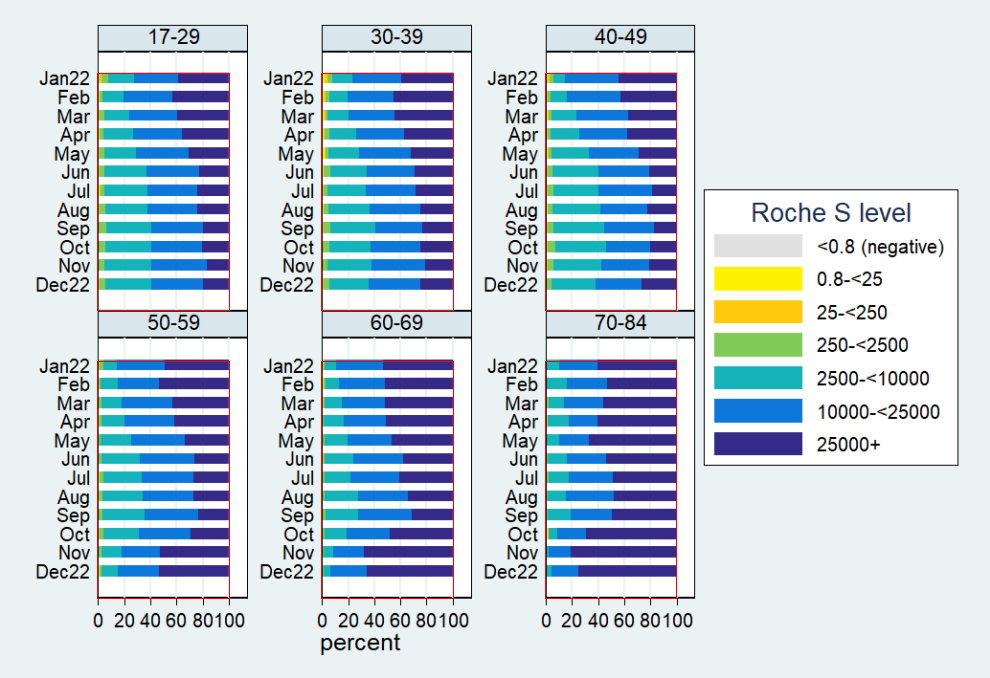

In [5]:
def extract_panels(image):
    top = 0.108
    diff = 0.0039
    left = 0.0947 + diff
    width = 0.137 - diff
    height = 0.35
    dist_x = 0.226
    dist_y = 0.425

    x_count = 3
    y_count = 2
    panels = []
    image2=image.copy()
    for y in range(y_count):
        for x in range(x_count):
            panels.append(get_rectangle(image, left + x*dist_x, top + y*dist_y, width, height))
            image2= draw_rectangle(image2, left + x*dist_x, top + y*dist_y, width, height)


    display(image2)
    

    return panels

image = open_image_and_crop("input/b.png")
panels = extract_panels(image)

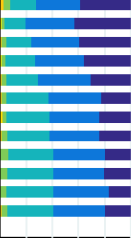

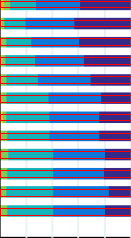

[<PIL.Image.Image image mode=RGB size=131x7 at 0x7FB0847BD370>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB0C5E73490>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB0847BDFD0>,
 <PIL.Image.Image image mode=RGB size=131x6 at 0x7FB08474D100>,
 <PIL.Image.Image image mode=RGB size=131x6 at 0x7FB08474D070>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB08474D2B0>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB08474DA30>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB08474DCD0>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB0847BDEE0>,
 <PIL.Image.Image image mode=RGB size=131x7 at 0x7FB0847BDF40>,
 <PIL.Image.Image image mode=RGB size=131x6 at 0x7FB0846B4520>,
 <PIL.Image.Image image mode=RGB size=131x6 at 0x7FB0847BDD60>]

In [12]:
def extract_bars(panel):
    top = 0.005
    left= 0 
    width =1
    height = 0.028
    dist_y= 0.0792
    total_bars = 12
    bars = []
    display(panel)
    image2= panel.copy()

    for y in range(total_bars):
        bars.append(get_rectangle(panel, left, top + y*dist_y, width, height))
        image2= draw_rectangle(image2, left, top + y*dist_y, width, height)
    display(image2)
    return bars
    
extract_bars(panels[0])

In [7]:

def distance(color1, color2):
    return (color1[0] - color2[0])**2 + (color1[1] - color2[1])**2 + (color1[2] - color2[2])**2
def find_closest_color_index(color, colors):
    min_distance = distance(color, colors[0])
    min_index = 0
    for i in range(len(colors)):
        d = distance(color, colors[i])
        if d < min_distance:
            min_distance = d
            min_index = i
    return min_index
def get_color_proportions(image, colors):
    # return the proportions of pixels in the image that are the closest match to each color
    closest = []
    for x in range(image.width):
        for y in range(image.height):
            closest.append(find_closest_color_index(image.getpixel((x, y)), colors))
    return [closest.count(i)/len(closest) for i in range(len(colors))]



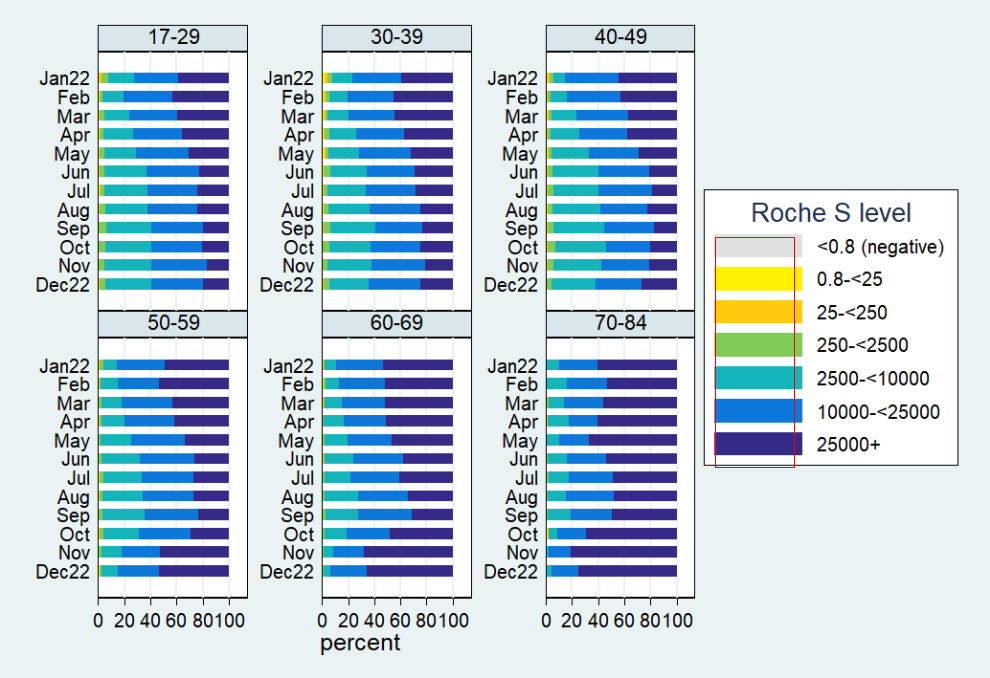

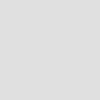

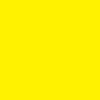

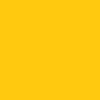

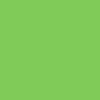

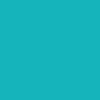

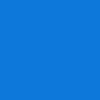

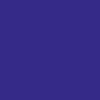

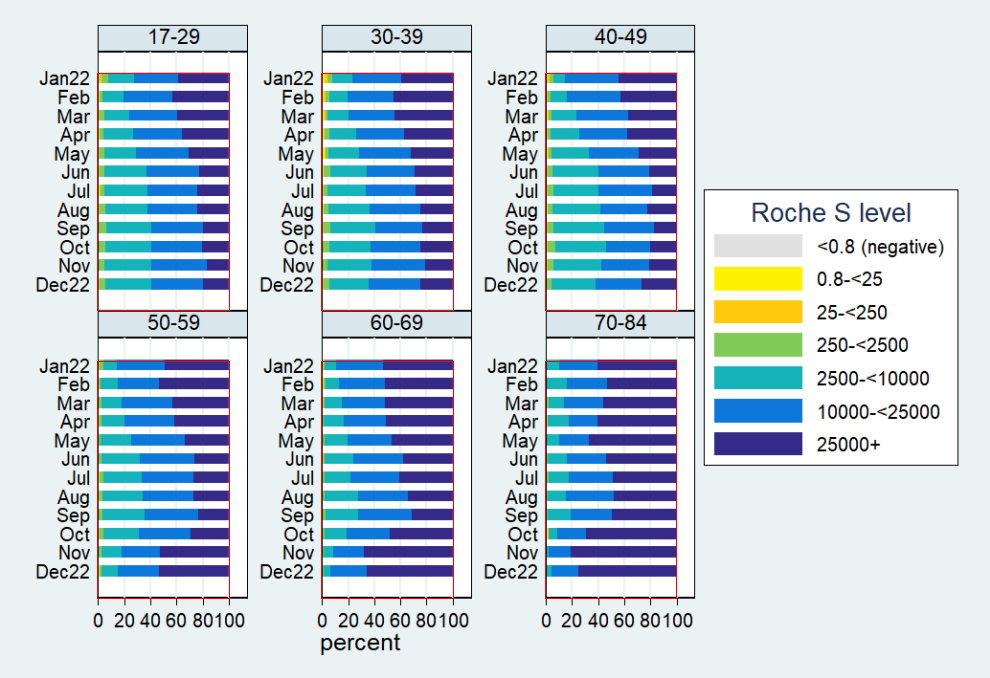

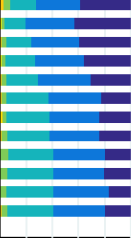

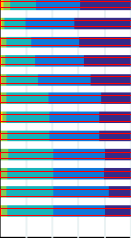

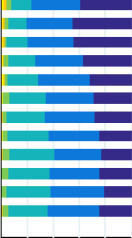

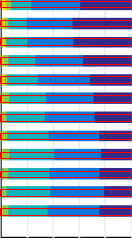

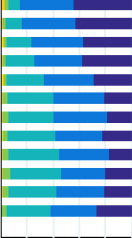

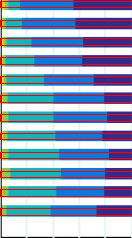

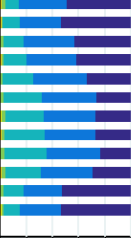

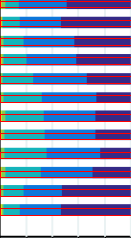

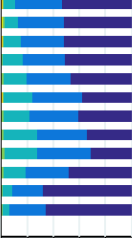

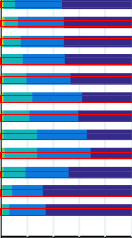

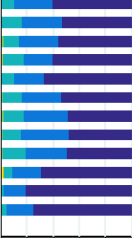

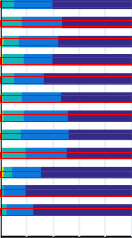

In [10]:
file = "input/b.png"
n_positive = process_file(file)

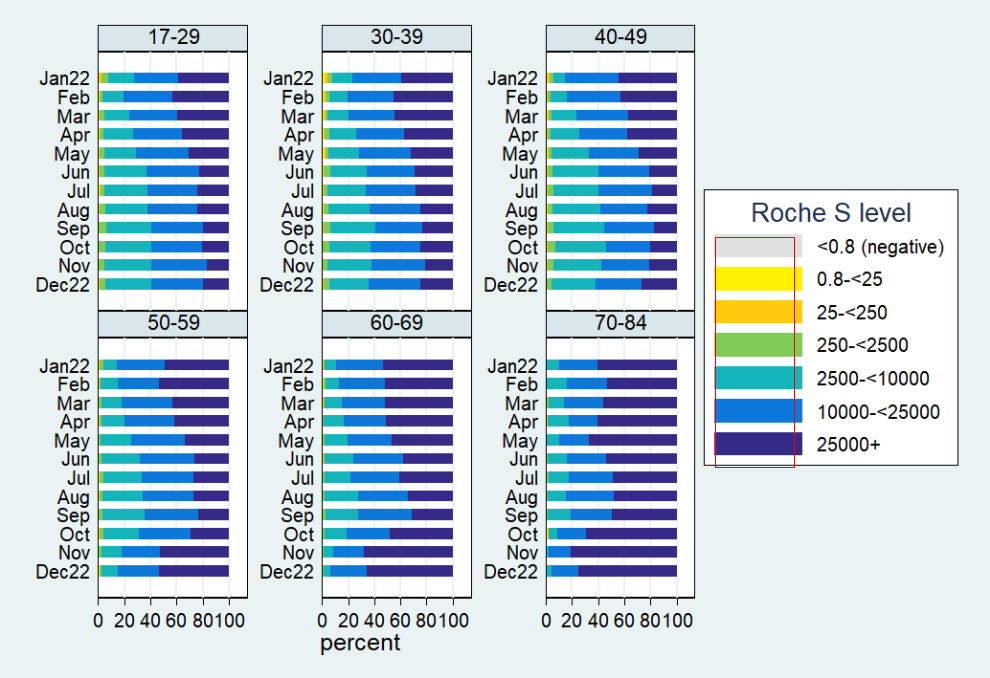

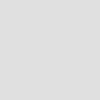

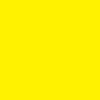

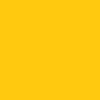

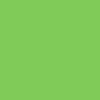

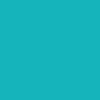

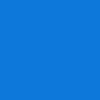

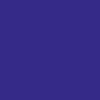

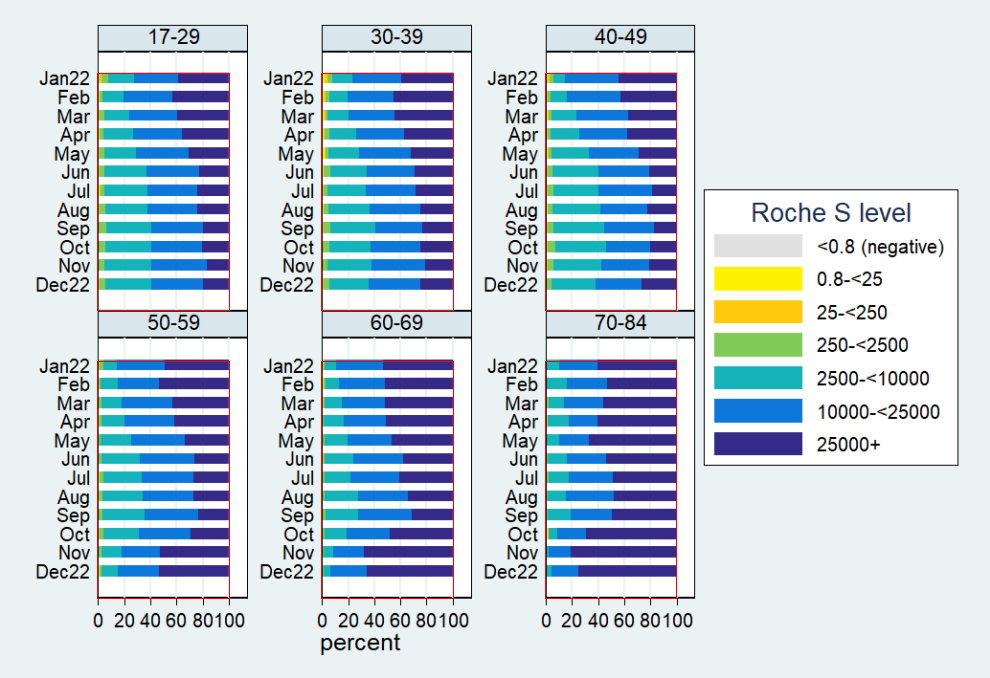

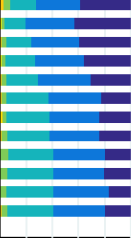

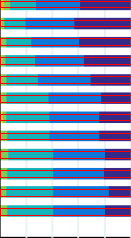

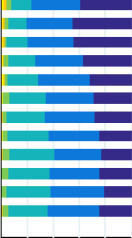

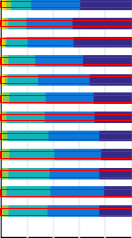

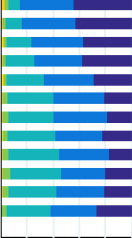

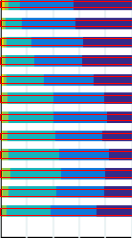

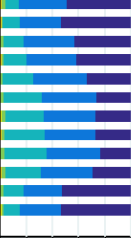

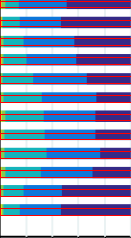

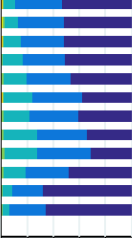

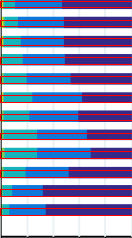

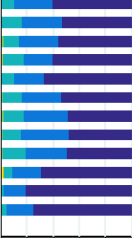

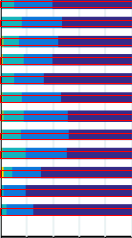

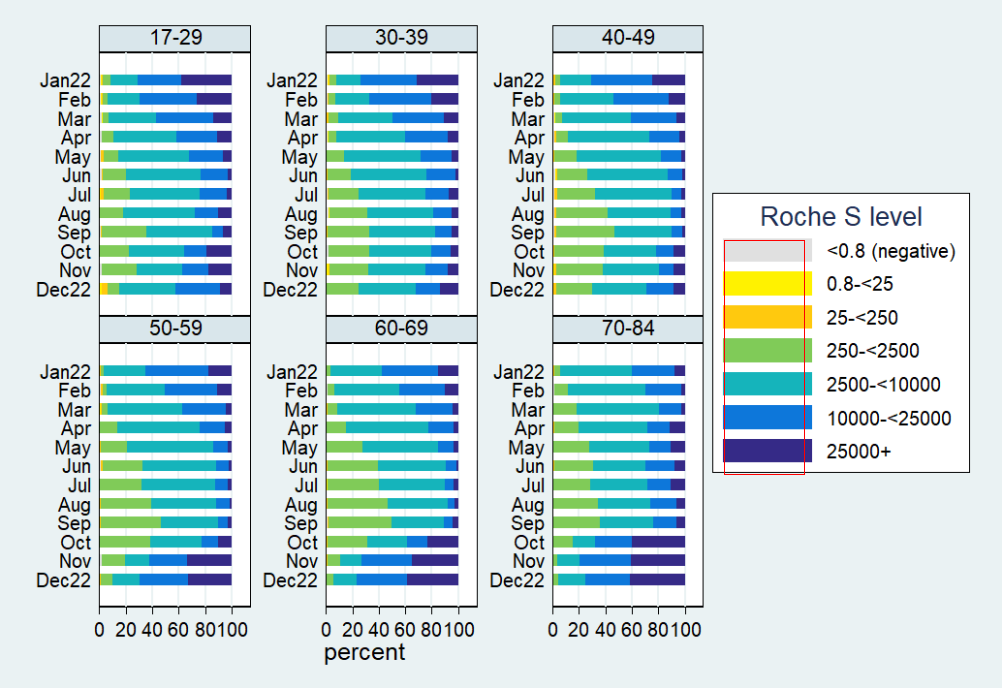

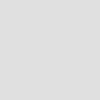

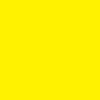

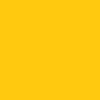

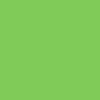

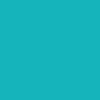

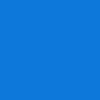

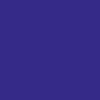

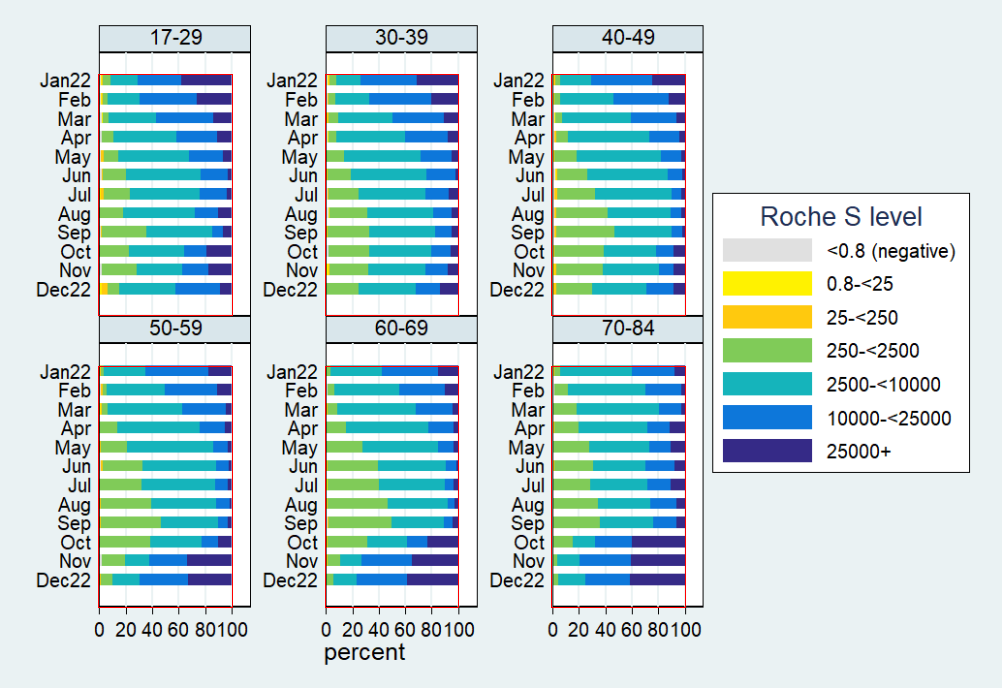

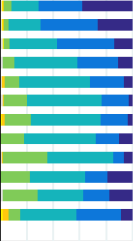

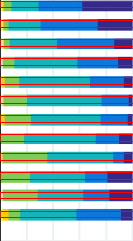

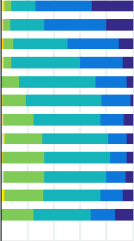

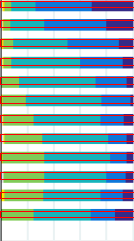

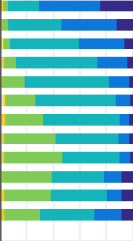

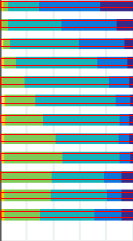

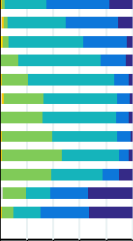

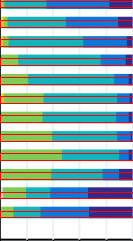

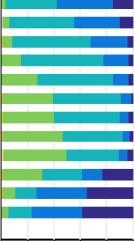

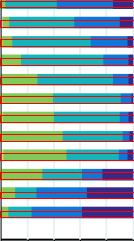

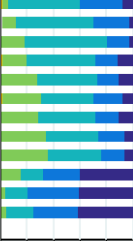

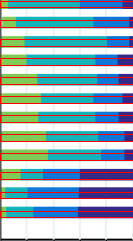

<ipython-input-13-e9aedd7d3d5d>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = n_positive.append(n_negative)


In [13]:
def process_panel(panel, age , colors, values):
    output = []
    bars = extract_bars(panel)
    for bar_index, bar in enumerate(bars):
        display(bar)
        color_props = get_color_proportions(bar, colors)
        for color_index, prop in enumerate(color_props):
            result = { "month": dates[bar_index], "titre": values[color_index], "proportion": prop, "age": age}
            output.append(result)
    return output


dates = ["Jan-2022","Feb-2022","Mar-2022","Apr-2022","May-2022","Jun-2022","Jul-2022","Aug-2022","Sep-2022","Oct-2022","Nov-2022","Dec-2022"]
ages = ["17-29","30-39","40-49","50-59","60-69","70-84"]
values = ["<0.8", "0.8-25","25-250","250-2500","2500-10000","10000-25000","25000+"]

def process_file(filename):
    image = open_image_and_crop(filename)
    colors = get_key(image)
    panels = extract_panels(image)
    output = []
    for panel_index, panel in enumerate(panels):
        output += process_panel(panel, ages[panel_index], colors, values)
    # as dataframe 
    df = pd.DataFrame(output)
    return df

file = "input/b.png"
n_positive = process_file(file)
file = "input/a.png"
n_negative = process_file(file)
n_positive["N"] = "positive"
n_negative["N"] = "negative"
combined = n_positive.append(n_negative)
combined.to_csv("combined.csv")


In [68]:
output

,month,titre,proportion,age
0,Mar-2021,<0.8,0.738255,17-29
1,Mar-2021,0.8-25,0.033557,17-29
2,Mar-2021,25-250,0.154362,17-29
3,Mar-2021,250-2500,0.026846,17-29
4,Mar-2021,2500-10000,0.040268,17-29
...,...,...,...,...
499,Feb-2022,25-250,0.000000,70-84
500,Feb-2022,250-2500,0.107383,70-84
501,Feb-2022,2500-10000,0.577181,70-84
502,Feb-2022,10000-25000,0.275168,70-84
